### Modelling distortions in narratives

An (overfitted) transformer-based model such as GPT-2 can memorise its training data. Here we explore distortions in the resulting model when trained on narratives, comparing the results to Raykov et al. (2023).

Three types of story from the ROC Stories dataset are consolidated into the model.

#### Imports:

In [41]:
import sys
sys.path.append('../scripts')

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
from random import shuffle
import random
from story_utils import *
import pickle
import matplotlib.pyplot as plt
import numpy as np
import gc
import torch
import glob
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import t
import os

os.environ['WANDB_MODE'] = 'disabled'
random.seed(1)

/nfs/nhome/live/espens/.pyenv/versions/3.11.5/envs/my_venv_3115/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Functions:

In [42]:
class GPT:

    def __init__(self, base_model):
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
        self.model = GPT2LMHeadModel.from_pretrained(base_model)

    def continue_input(self, input_sequence, max_length=200, num_return_sequences=1, no_repeat_ngram_size=10,
                       do_sample=False, temperature=0, num_beams=1):

        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')
        max_length = len(input_ids[0]) + 100

        # Generate text
        output = self.model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

In [ ]:
def prepare_data(num_typical=100, num_char=50, num_variants=20):
    stories = get_stories()
    shuffle(stories)
    lengths = [len(s) for s in stories]
    mean_len = np.mean(lengths)
    mean_len = int(mean_len)
    print(mean_len)

    typical = stories[:num_typical]
    lengthened = []
    shortened = []
    for s in stories[num_typical:]:
        if len(s) < mean_len:
            delta = mean_len - len(s)
            # increase length up to average
            if delta > 100:
                new_s = s + get_random_sentence(stories)[0:delta]
                lengthened.append(new_s)
        if len(s) > mean_len:
            # decrease length down to average
            delta = len(s) - mean_len
            if delta > 100:
                new_s = s[0:mean_len]
                shortened.append(new_s)

    stories = [s + ' The end.' for s in stories]
    shortened = [s + ' The end.' for s in shortened]
    lengthened = [s + ' The end.' for s in lengthened]
    return stories[:num_typical], shortened[:num_variants], lengthened[:num_variants]

In [ ]:
def compute_length_difference(stories):
    """
    Computes the length difference between input and output for a given list of stories.
    """
    differences = []
    for story in stories:
        input_length = len(story[0])
        output_length = len(story[1])
        difference = output_length - input_length
        differences.append(difference)
        print(difference)
    return sum(differences) / len(differences)


In [3]:
def test_model(save_name, typical, atypical_short, atypical_long):

    model = GPT(base_model='outputs_stories')

    results_dict = {}
    results_dict['typical'] = []
    results_dict['atypical_short'] = []
    results_dict['atypical_long'] = []

    for s in typical[0:len(atypical_short)]:
        start = " ".join(s.split()[0:10])
        gen = model.continue_input(start)
        if 'The end.' in gen:
            gen = gen[0:gen.index('The end.')+8]
            print(f"START: \n{start}")
            print(f"GENERATED: \n{gen}")
            print(f"TRUE: \n{s}")
            results_dict['typical'].append([s, gen])

    for s in atypical_short:
        start = " ".join(s.split()[0:10])
        gen = model.continue_input(start)
        if 'The end.' in gen:
            gen = gen[0:gen.index('The end.')+8]
            print(f"START: \n{start}")
            print(f"GENERATED: \n{gen}")
            print(f"TRUE: \n{s}")
            results_dict['atypical_short'].append([s, gen])

    for s in atypical_long:
        start = " ".join(s.split()[0:10])
        gen = model.continue_input(start)
        if 'The end.' in gen:
            gen = gen[0:gen.index('The end.')+8]
            print(f"START: \n{start}")
            print(f"GENERATED: \n{gen}")
            print(f"TRUE: \n{s}")
            results_dict['atypical_long'].append([s, gen])


    # Calculate the average length difference for each category
    typical_difference = compute_length_difference(results_dict['typical'])
    atypical_short_difference = compute_length_difference(results_dict['atypical_short'])
    atypical_long_difference = compute_length_difference(results_dict['atypical_long'])

    # Plotting the results
    categories = ['Atypical Short', 'Typical', 'Atypical Long']
    differences = [atypical_short_difference, typical_difference, atypical_long_difference]

    plt.figure()
    plt.bar(categories, differences)
    plt.xlabel('Story Category')
    plt.ylabel('Average Length Difference (Output - Input)')
    plt.title('Length Difference by Story Category')
    plt.axhline(y=0, color='black')
    plt.savefig(save_name)
    plt.show()

    with open(save_name + '.pkl', 'wb') as handle:
        pickle.dump(results_dict, handle)

    return results_dict

#### Train models

In [ ]:
def train_model_script(name_or_path='gpt2-medium',
                       num_epochs=3,
                       output_dir='outputs_stories',
                       save_steps=1000,
                       lr=5e-04):
    gc.collect()
    ! python3 run_clm.py \
        --model_name_or_path {name_or_path} \
        --train_file {'./outputs_stories/train.txt'} \
        --validation_file {'./outputs_stories/train.txt'} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps {save_steps} \
        --learning_rate {lr} \
        --report_to 'none'

for i in range(0, 10):
    for num_typical in [100]:
        for num_char in [100]:
            for num_variants in [10]:
                for num_eps in [5]:

                    !rm -rf outputs_stories
                    !mkdir outputs_stories

                    typical, atypical_short, atypical_long = prepare_data(num_typical=num_typical,
                                                                          num_variants=num_variants)
                    sents_list = typical + atypical_short + atypical_long
                    #sents_list = np.random.choice(sents_list, 100).tolist()
                    shuffle(sents_list)

                    with open("outputs_stories/train.txt", "w") as fh:
                        fh.write('\n'.join(sents_list))

                    with open("outputs_stories/test.txt", "w") as fh:
                        fh.write('\n'.join(sents_list))

                    train_model_script(num_epochs=num_eps)

                    test_model(f'./plots/{i}trial_{num_eps}epochs_{num_typical}typicals_{num_char}chars_{num_variants}variants.png',
                              typical,
                              atypical_short,
                              atypical_long)

#### Analyse results

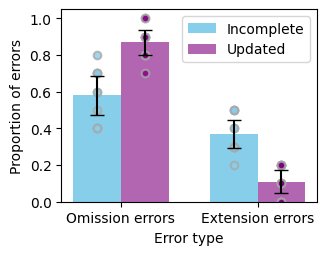

In [43]:
# Function to compare lengths of input and output
def length_comparison(category_data):
    shorter, same, longer = 0, 0, 0
    total_stories = 10  # Each .pkl file has exactly 10 stories in each category
    
    for input_text, output_text in category_data:
        if len(output_text) < len(input_text):
            shorter += 1
        elif len(output_text) == len(input_text):
            same += 1
        else:
            longer += 1
    
    # Ensure we divide by 10 to get fractions (since each .pkl has 10 stories)
    return shorter / total_stories, same / total_stories, longer / total_stories  # Return fractions

# Function to calculate 95% confidence intervals
def calculate_95_ci(data):
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)  # Standard error of the mean
    ci_range = t.ppf(0.975, df=n-1) * sem    # 95% CI (two-tailed, so 0.975 for upper bound)
    return mean, ci_range

# Key remapping dictionary
key_mapping = {
    'typical': 'typical',
    'atypical_short': 'incomplete',
    'atypical_long': 'updated'
}

# Categories to compare
categories = ['incomplete', 'updated']

# Initialize lists to store results for each individual
individual_results = {'incomplete': {'shorter': [], 'longer': []},
                      'updated': {'shorter': [], 'longer': []}}

# Load each .pkl file separately, treating each as an individual
for pkl in glob.glob('event_data/*.pkl'):
    with open(pkl, 'rb') as f:
        d = pickle.load(f)
    
    # Remap the keys from 'typical', 'atypical_short', 'atypical_long' to 'typical', 'incomplete', 'updated'
    remapped_data = {key_mapping[k]: v for k, v in d.items()}
    
    # Calculate fractions for each category for this individual
    for category in categories:
        shorter, _, longer = length_comparison(remapped_data.get(category, []))
        individual_results[category]['shorter'].append(shorter)
        individual_results[category]['longer'].append(longer)

# Convert individual results to arrays for easier manipulation
incomplete_shorter = np.array(individual_results['incomplete']['shorter'])
incomplete_longer = np.array(individual_results['incomplete']['longer'])
updated_shorter = np.array(individual_results['updated']['shorter'])
updated_longer = np.array(individual_results['updated']['longer'])

# Calculate means and 95% CI for each error type
mean_incomplete_shorter, ci_incomplete_shorter = calculate_95_ci(incomplete_shorter)
mean_incomplete_longer, ci_incomplete_longer = calculate_95_ci(incomplete_longer)
mean_updated_shorter, ci_updated_shorter = calculate_95_ci(updated_shorter)
mean_updated_longer, ci_updated_longer = calculate_95_ci(updated_longer)

means_incomplete = [mean_incomplete_shorter, mean_incomplete_longer]
means_updated = [mean_updated_shorter, mean_updated_longer]

ci_incomplete = [ci_incomplete_shorter, ci_incomplete_longer]
ci_updated = [ci_updated_shorter, ci_updated_longer]

labels = ['Omission errors', 'Extension errors']
x = np.arange(len(labels)) 
bar_width = 0.35 


fig, ax = plt.subplots(figsize=(3.3, 2.5))
ax.bar(x - bar_width/2, means_incomplete, bar_width, yerr=ci_incomplete, color='skyblue', alpha=1, label='Incomplete', capsize=5)
ax.bar(x + bar_width/2, means_updated, bar_width, yerr=ci_updated, color='purple', alpha=0.6, label='Updated', capsize=5)

# Plot individual points with optional jitter offset
jitter_amount=0.00
ax.scatter(x[0] - bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(incomplete_shorter)), 
           incomplete_shorter, color='skyblue', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

ax.scatter(x[1] - bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(incomplete_longer)), 
           incomplete_longer, color='skyblue', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

ax.scatter(x[0] + bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(updated_shorter)), 
           updated_shorter, color='purple', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

ax.scatter(x[1] + bar_width/2 + np.random.uniform(-jitter_amount, jitter_amount, len(updated_longer)), 
           updated_longer, color='purple', s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)

ax.set_xlabel('Error type')
ax.set_ylabel('Proportion of errors')
ax.set_xticks(x)
ax.set_ylim(0, 1.05)
ax.set_xticklabels(labels)
ax.legend()

plt.savefig('omission_vs_extension_with_individuals_95CI.png', bbox_inches='tight', dpi=500)
plt.show()

Extra plot:

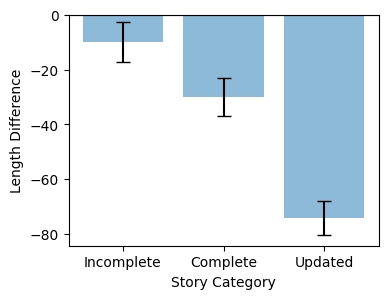

In [44]:
def compute_length_difference_and_sem(stories):
    """
    Computes the length difference and SEM between input and output for a given list of stories.
    """
    differences = []
    for story in stories:
        input_length = len(story[0])
        output_length = len(story[1])
        difference = output_length - input_length
        differences.append(difference)
    average_difference = sum(differences) / len(differences)
    # Calculate SEM
    sem = np.std(differences, ddof=1) / np.sqrt(len(differences))
    return average_difference, sem

combined = {'typical': [], 'atypical_short': [], 'atypical_long': []}
for pkl in glob.glob('event_data/*.pkl'):
    with open(pkl, 'rb') as f:
        d = pickle.load(f)
    combined['typical'].extend(d['typical'])
    combined['atypical_long'].extend(d['atypical_long'])
    combined['atypical_short'].extend(d['atypical_short'])

# Calculate the average length difference and SEM for each category
typical_difference, typical_sem = compute_length_difference_and_sem(combined['typical'])
atypical_short_difference, atypical_short_sem = compute_length_difference_and_sem(combined['atypical_short'])
atypical_long_difference, atypical_long_sem = compute_length_difference_and_sem(combined['atypical_long'])

# Plotting the results with error bars
categories = ['Incomplete', 'Complete', 'Updated']
differences = [atypical_short_difference, typical_difference, atypical_long_difference]
sems = [atypical_short_sem, typical_sem, atypical_long_sem]  # SEMs for error bars

plt.figure(figsize=(4,3))
plt.bar(categories, differences, yerr=sems, capsize=5, alpha=0.5)  # Add error bars with capsize
plt.xlabel('Story Category')
plt.ylabel('Length Difference')
plt.axhline(y=0, color='black')
plt.savefig('event_ext.png', dpi=500, bbox_inches='tight')
plt.show()


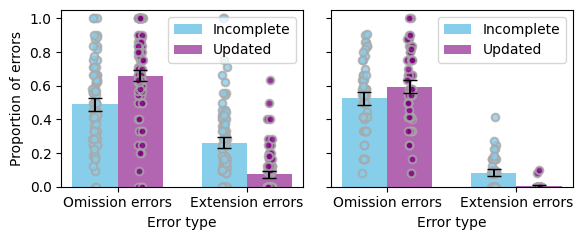

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t

# -----------------------------
# Load and process the data
# -----------------------------
df = pd.read_csv("Exp_5b_vs_Exp_4.csv", sep=',')
# Map Condition for readability: 0 -> 'Incomplete', 1 -> 'Updated'
df['Condition'] = df['Condition'].map({0: 'Incomplete', 1: 'Updated'})

# -----------------------------
# Compute means and 95% CIs for each error type
# -----------------------------
# For Extension errors:
grouped_ext = df.groupby(['Study', 'Condition'])['Extension']
means_ext = grouped_ext.mean().unstack()  # rows=Study, columns=Condition
cis_ext = grouped_ext.apply(lambda x: t.ppf(0.975, df=len(x)-1) * x.sem()).unstack()

# For Omission errors:
grouped_om = df.groupby(['Study', 'Condition'])['Omission']
means_om = grouped_om.mean().unstack()
cis_om = grouped_om.apply(lambda x: t.ppf(0.975, df=len(x)-1) * x.sem()).unstack()

# Define studies and conditions of interest.
studies = ['delayed', 'immediate']
conditions = ['Incomplete', 'Updated']

# -----------------------------
# Plot settings
# -----------------------------
# Two error types: 'Omission errors' and 'Extension errors'
categories = ['Omission errors', 'Extension errors']
x = np.arange(len(categories))  # [0, 1]
bar_width = 0.35

colors = {'Incomplete': 'skyblue', 'Updated': 'purple'}
alphas = {'Incomplete': 1.0, 'Updated': 0.6}
jitter_amount = 0.02

# Create subplots: one for delayed, one for immediate
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True)

for idx, study in enumerate(studies):
    ax = axs[idx]
    # For each error type, collect data for each condition.
    # For "Incomplete" condition:
    #   - Omission error mean: from means_om.loc[study, 'Incomplete']
    #   - Extension error mean: from means_ext.loc[study, 'Incomplete']
    y_incomplete = np.array([
        means_om.loc[study, "Incomplete"],
        means_ext.loc[study, "Incomplete"]
    ])
    yerr_incomplete = np.array([
        cis_om.loc[study, "Incomplete"],
        cis_ext.loc[study, "Incomplete"]
    ])
    # For "Updated" condition:
    y_updated = np.array([
        means_om.loc[study, "Updated"],
        means_ext.loc[study, "Updated"]
    ])
    yerr_updated = np.array([
        cis_om.loc[study, "Updated"],
        cis_ext.loc[study, "Updated"]
    ])
    
    # Plot the bars for each condition.
    ax.bar(x - bar_width/2, y_incomplete, width=bar_width, yerr=yerr_incomplete, 
           capsize=5, label="Incomplete", color=colors["Incomplete"], alpha=alphas["Incomplete"])
    ax.bar(x + bar_width/2, y_updated, width=bar_width, yerr=yerr_updated, 
           capsize=5, label="Updated", color=colors["Updated"], alpha=alphas["Updated"])
    
    # Overlay individual participant scores.
    # For each study and condition, group by 'Sub_num' and compute mean error rate.
    # We do this separately for each error type.
    for cond in conditions:
        # For Omission errors:
        subset_om = df[(df['Study'] == study) & (df['Condition'] == cond)]
        # Group by participant.
        part_means_om = subset_om.groupby('Sub_num')['Omission'].mean().values
        # For Extension errors:
        subset_ext = df[(df['Study'] == study) & (df['Condition'] == cond)]
        part_means_ext = subset_ext.groupby('Sub_num')['Extension'].mean().values
        
        if cond == "Incomplete":
            xpos_om = x[0] - bar_width/2
            xpos_ext = x[1] - bar_width/2
        else:
            xpos_om = x[0] + bar_width/2
            xpos_ext = x[1] + bar_width/2
        
        # Add jitter.
        x_positions_om = np.full(len(part_means_om), xpos_om) + np.random.uniform(-jitter_amount, jitter_amount, len(part_means_om))
        x_positions_ext = np.full(len(part_means_ext), xpos_ext) + np.random.uniform(-jitter_amount, jitter_amount, len(part_means_ext))
        
        ax.scatter(x_positions_om, part_means_om, color=colors[cond], s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)
        ax.scatter(x_positions_ext, part_means_ext, color=colors[cond], s=30, edgecolors='darkgrey', linewidth=1.5, alpha=0.8)
    
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_xlabel('Error type')
    #ax.set_title(study.capitalize())

axs[0].set_ylabel('Proportion of errors')
axs[0].set_ylim(0, 1.05)
axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('raykov_data.png', dpi=300)
plt.show()
